In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
birds_recep_df = sc.read.json('datos/all-birds-data.jsonlines/')
birds_recep = birds_recep_df.rdd

In [5]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

In [6]:
from pyspark.sql.functions import split

count_by_date = birds_recep_df.withColumn('timestamp', split('timestamp', ' ')[0]).groupby('tag_id', 'timestamp').count()


In [82]:
df = count_by_date.toPandas()

In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [44]:
df_female = df[df['tag_id'].isin(FEMALES)]
df_male = df[df['tag_id'].isin(MALES)]

In [94]:
def show_emmisions_count(df, title):
    df1 = df[df.tag_id < 22]
    df2 = df[(df.tag_id >= 22) & (df.tag_id < 29)]
    df3 = df[(df.tag_id >= 29)]
    
    df1 = df1.pivot(index='timestamp', columns='tag_id', values='count')
    df2 = df2.pivot(index='timestamp', columns='tag_id', values='count')
    df3 = df3.pivot(index='timestamp', columns='tag_id', values='count')
    
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(3):
        axes[i].axvline(pd.Timestamp(2018, 1, 10))
    fig.suptitle(title)

    df1.plot(ax=axes[0], xlim=(pd.Timestamp('2017-12-29'), pd.Timestamp('2018-03-10')), ylim=(0,13000), legend=False)
    df2.plot(ax=axes[1], xlim=(pd.Timestamp('2017-12-29'), pd.Timestamp('2018-03-10')), ylim=(0,13000), legend=False)
    df3.plot(ax=axes[2], xlim=(pd.Timestamp('2017-12-29'), pd.Timestamp('2018-03-10')), ylim=(0,13000), legend=False)


<IPython.core.display.Javascript object>


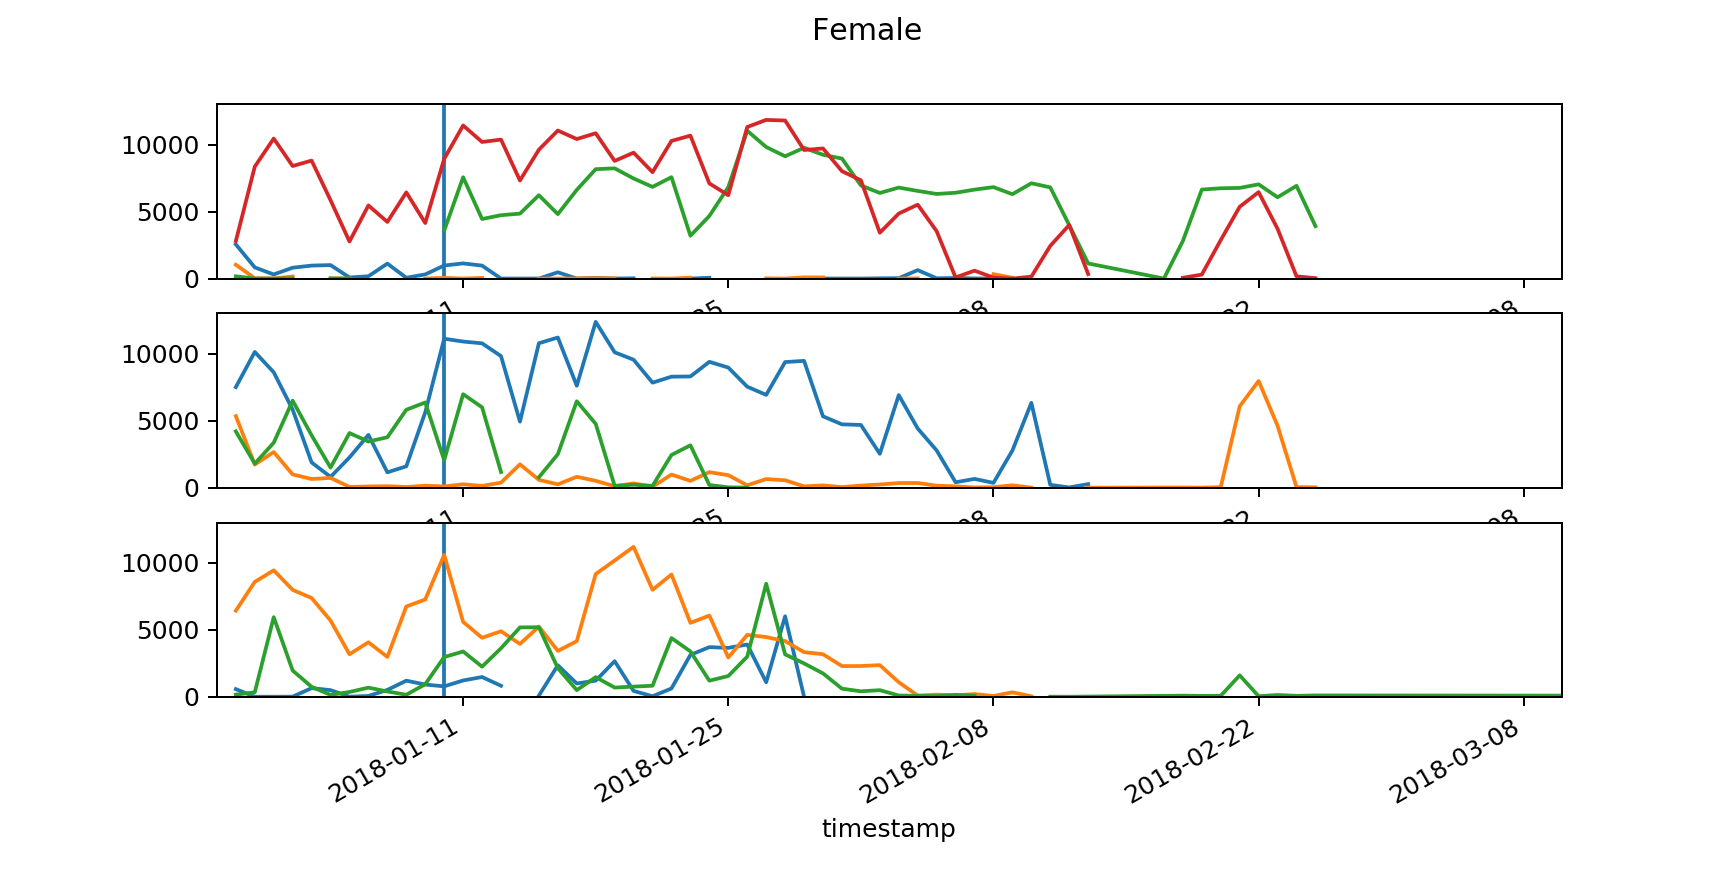

In [95]:
show_emmisions_count(df_female, 'Female')

<IPython.core.display.Javascript object>


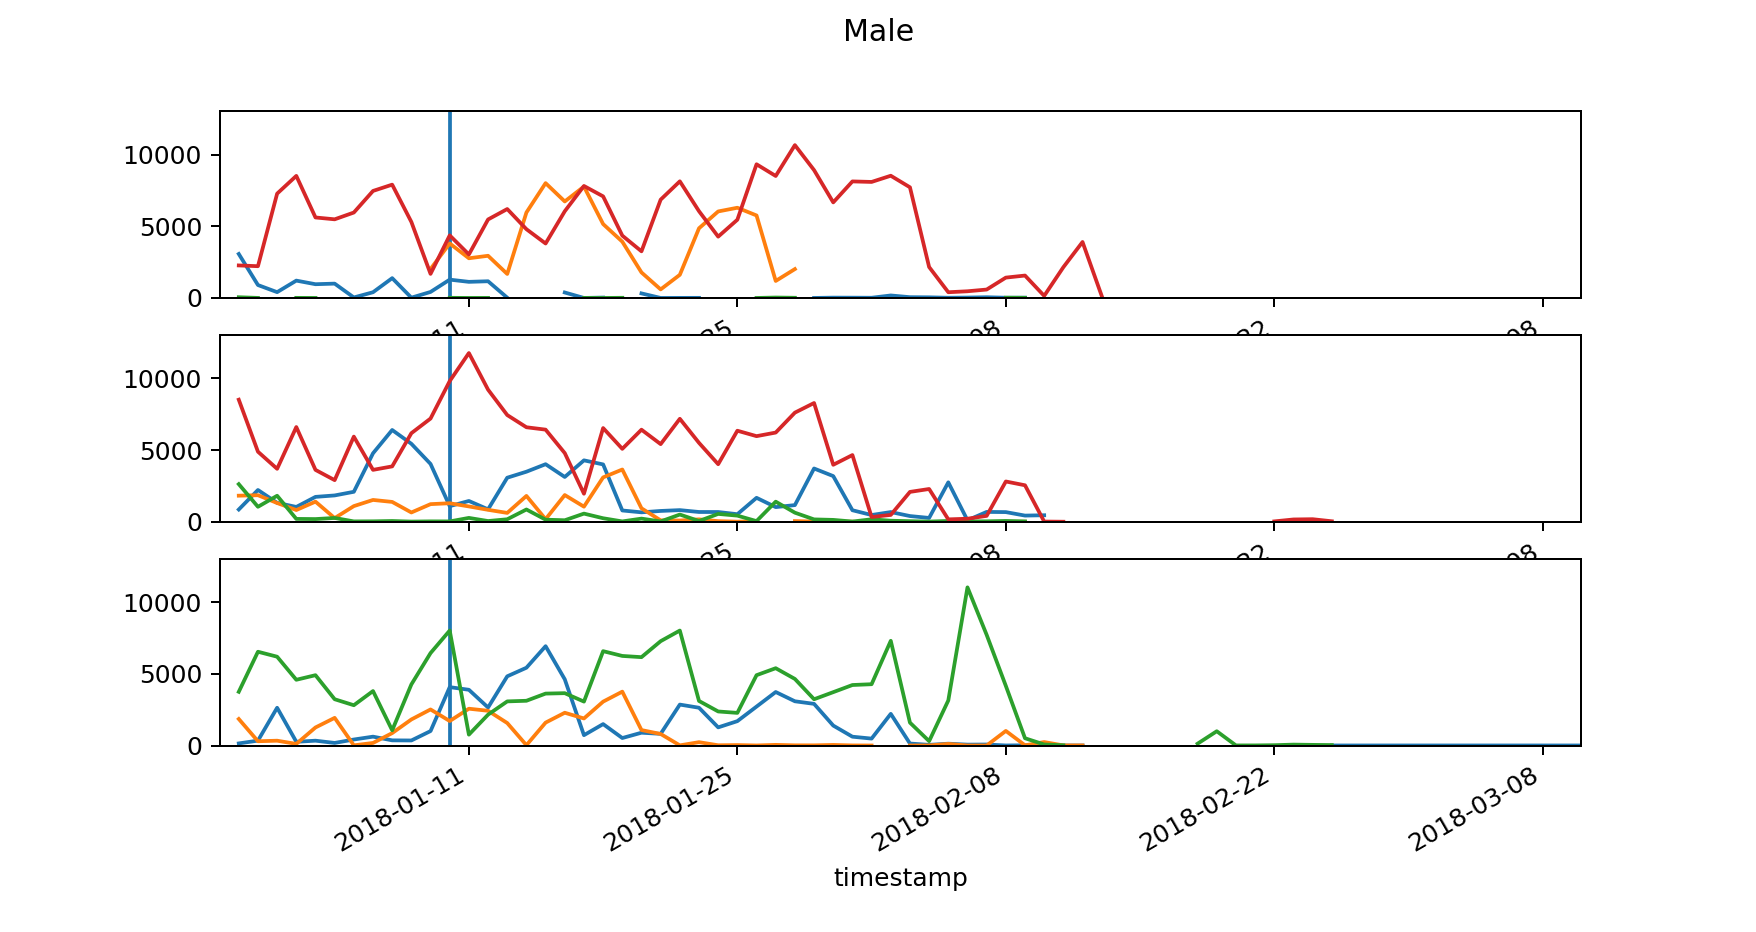

In [96]:
show_emmisions_count(df_male, 'Male')

## Utils

### Cantidad de recepciones por antena

#### (2) ¿Todas las antenas tienen el mismo impacto? ¿O hay antenas con más emisiones/más puntos alcanzables?

In [ ]:
cants_recep_por_antena = []
for i in range(4):
    cant = birds_recep.filter(lambda x: x['recep_{}'.format(i)] > 0).count()
    cants_recep_por_antena.append({'antenna': i, 'cant_recep': cant})
    
p = pd.DataFrame(cants_recep_por_antena).plot.bar(x='antenna', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de recepciones')
p.set_xlabel('Numero de antena')


### Promedio y stdev de las potencias recibidas por antena

#### (3.5) ¿Todas las antenas reciben señales con la misma intensidad?

In [ ]:
same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = birds_recep.filter(lambda x: x[recep_field] > 0).map(lambda x: x[recep_field])
    mean = recepciones.mean()
    stdev = recepciones.stdev()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})
    
p = pd.DataFrame(same_emisions_mean_and_std).plot.bar(x='antenna', y='mean', yerr='stdev', legend=False)
p.set_ylabel('Promedio de la potencia recibida')
p.set_xlabel('Numero de antena')


### Cantidad de emisions que usan _x_ cantidad de antenas

#### (9) ¿Cuantos emisiones usan 1 antena? ¿Y 2 antenas?

In [ ]:
cant_recep = birds_recep.groupBy(lambda x: sum([x['recep_{}'.format(i)] > 0 for i in range(4)])).map(lambda x: {'antennas': x[0],'cant_recep': len(x[1])})

p = pd.DataFrame(cant_recep.collect()).plot.bar(x='antennas', y='cant_recep', legend=False)
p.set_ylabel('Cantidad de emisiones')
p.set_xlabel('Cantidad de antenas')

## Cantidad de emisiones (es decir, agrupamiento de recepciones) por pajaro

In [ ]:
cant_by_bird = birds_recep.groupBy(lambda x: x['tag_id']).map(lambda x: {'tag_id': x[0],'cant_emisiones': len(x[1])})

p = pd.DataFrame(cant_by_bird.collect()).plot.bar(x='tag_id', y='cant_emisiones', legend=False)
p.set_ylabel('Cantidad de emisiones')
p.set_xlabel('Pajaros')

## Promedio de antenas usadas por pajaro

In [ ]:
cant_by_bird = (
    birds_recep
    .map(lambda x: {'tag_id': x['tag_id'], 'cant_recep': sum([x['recep_{}'.format(i)] > 0 for i in range(4)])})
    .groupBy(lambda x: x['tag_id'])
    .map(lambda x: {'tag_id': x[0],'cant_recep': np.mean(list(map(lambda e: e['cant_recep'], x[1])))})
)

p = pd.DataFrame(cant_by_bird.collect()).plot.bar(x='tag_id', y='cant_recep', legend=False)
p.set_ylabel('Promedio antenas usadas')
p.set_xlabel('Pajaros')